Testing different ways to calculate the differentiable log likelihood. The one that works is in `core.loglikelihood_hilbert()`.

In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels

#jax.config.update("jax_debug_nans", True)

def translated_kernelmatrix(theta, offset):
    poles = core.make_poles(theta['bandwidth'], theta['frequency'])
    R = core.kernelmatrix_root_convolved_gfd(
        kernel, theta['var'], theta['scale'],
        t - offset, M, theta['T'], c, poles
    )
    return R

def _vmap_axis(v, P):
    return 0 if v.shape[0] == P else None

def kernelmatrix_root(theta, P):
    in_axes = {k: _vmap_axis(v, P) for k, v in theta.items()}
    if in_axes['T'] == 0:
        offset = jnp.cumsum(theta['T'])
    else:
        offset = jnp.cumsum(jnp.repeat(theta['T'], P))
    
    R = jax.vmap(translated_kernelmatrix, (in_axes, 0), 0)(theta, offset) # (P, N, M)
    R = jnp.hstack(R) # (N, P*M)
    return R

from IPython.display import Audio

def play(y, resample_rate=None, autoplay=True):
    """resample_rate must be in Hz"""
    rate = int(1000./dt)
    if resample_rate:
        y = resample(y, int(len(y)*resample_rate/rate))
        rate = resample_rate
    return Audio(y, rate=rate, autoplay=autoplay, normalize=True)

2022-11-24 15:42:54.155774: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


(3710, 6400)


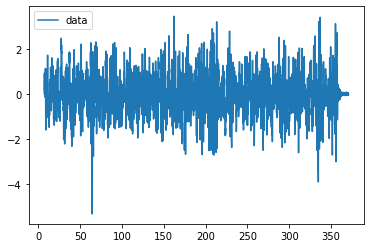

In [2]:
P = 50 # number of pitch periods
T = 7. # msec
fs = 10. # kHz
N = int((P+3)*T*fs)

# The smoother the kernel, the harder the ridge regression
# For SqExponentialKernel and CenteredSincKernel we need sufficiently short scales
# The MaternXXKernels seem to work
kernel = isokernels.Matern12Kernel
M = 128 #kernel.M
c = 2.
L = T*c
var = 1.
r = 1/np.pi*2
scale = r*T
noise_power = 1e-3
t, dt = jnp.linspace(T, (P+3)*T, N, retstep=True)

bandwidth = jnp.array([110, 150, 200, 300], dtype=float64)
frequency = jnp.array([700, 2500, 2750, 4500], dtype=float64)

def jitter(): return jnp.exp(randn(P)/10)

theta = {
    'T': jnp.ones(P)*T*jitter(), # (P,)
    'var': jnp.array([1.]), # Broadcast
    'scale': jnp.ones(P)*scale*jitter(),
    'bandwidth': bandwidth, # Broadcast
    'frequency': jnp.repeat(frequency[None,:], P, axis=0) * jitter()[:,None], # (P,:)
    'noise_power': jnp.array([noise_power]) # Broadcast
}

R = kernelmatrix_root(theta, P)
print(R.shape)

w = randn(R.shape[1])
f = R @ w + sqrt(noise_power)*randn(N)
plot(t, f, label="data")
legend()

# Matern12Kernel is like whispering
play(f)

/tmp/ipykernel_368566/868948894.py:1: RuntimeWarning: divide by zero encountered in log10
  matshow(log10(abs(R)))


DeviceArray(0.46702965, dtype=float64)

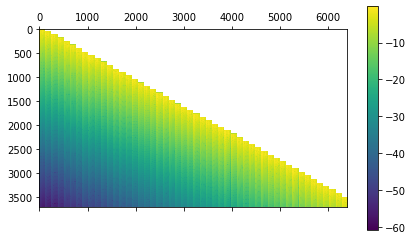

In [3]:
matshow(log10(abs(R)))
colorbar()
sum(R==0.)/prod(R.shape)

(DeviceArray(47.81792552, dtype=float64),
 {'T': DeviceArray([ -5.75243479,  -7.00984592,  -6.56483494,  -9.26055761,
                -5.0064779 ,  -6.12553483,  -6.67768664,  -8.10938074,
                -5.27804531,  -5.89625097,  -6.45545274,  -9.44595276,
                -4.8716061 , -10.30381481,  -8.41422667, -10.71024456,
                -0.54342657,  -0.40651703,  -1.7686297 ,  -2.94825433,
                 1.52356133,  -1.0011366 ,   2.41142441,   2.24540829,
                 0.14687686,   2.98265331,   3.71864291,   2.32493144,
                 2.45553232,   1.10876956,   4.61439679,   2.30832921,
                 3.65216328,   2.25427957,   1.86154589,   2.6346175 ,
                 1.14087365,   0.60799421,   0.11582682,  -2.15828373,
                 1.71712777,   1.21974487,   2.85747063,   0.50939887,
                -0.72386148,   0.86413449,  -1.01802505,  -0.79172189,
                 2.24044697,   3.22488409], dtype=float64),
  'bandwidth': DeviceArray([ 0.01727067, 

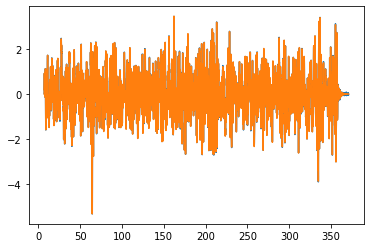

In [4]:
# Use ridge regression, own implementation. DO NOT USE: gradients are a bit
# more unstable compared to cg() implementation below

def fit(theta, data):
    noise_power = jnp.squeeze(theta['noise_power'])
    R = kernelmatrix_root(theta, P)
    pinv = jnp.linalg.inv(R.T @ R + noise_power*jnp.eye(R.shape[1])) @ R.T
    x = pinv @ data
    return x

x = fit(theta, f)
plot(t, f, label="data")
plot(t, R @ x, label="fit")

def fit_norm(theta, data): # Dummy function to differentiate
    return jnp.linalg.norm(fit(theta, data))

jax.value_and_grad(fit_norm)(theta, f) # Unstable gradient

(DeviceArray(38.78437426, dtype=float64),
 {'T': DeviceArray([ 0.16936686,  0.14754378,  0.16610578, -0.05822347,
                0.3416579 ,  0.34870509,  0.28814545,  0.33631936,
                0.5409763 ,  0.12622305,  0.08045834,  0.16070003,
                0.09970861, -0.04942856, -0.10562889, -0.25181444,
                0.22741943, -0.06355738,  0.08261745, -0.07976523,
                0.16492223,  0.12112559,  0.16770429,  0.14370521,
                0.19839173,  0.13443054,  0.08897006,  0.22248561,
                0.23051666,  0.12187621,  0.07406942, -0.04353242,
                0.29429905,  0.25584701,  0.17646777,  0.33683978,
                0.10584014,  0.19076313,  0.07012503,  0.15692647,
                0.24387236, -0.10687391,  0.03518374,  0.28583557,
                0.09936201,  0.36395364,  0.46927822,  0.22356726,
                0.09110506,  0.04656126], dtype=float64),
  'bandwidth': DeviceArray([1.57074407e-02, 8.53499196e-03, 4.40529869e-03,
               

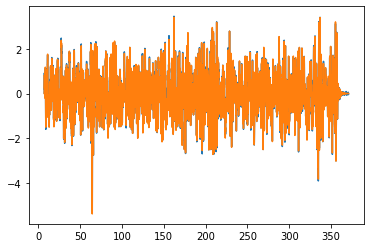

In [5]:
# Now using cg() with implicit differentiation. USE THIS

# From https://jaxopt.github.io/stable/auto_examples/implicit_diff/ridge_reg_implicit_diff.html
from jaxopt import implicit_diff
from jaxopt import linear_solve

MAX_CG_ITER = 25 # Reduce if too slow

@jax.jit
def ridge_objective(params, l2reg, data):
    """Ridge objective function for implicit differentiation"""
    X_tr, y_tr = data
    residuals = X_tr @ params - y_tr
    return 0.5 * jnp.mean(residuals ** 2) + 0.5 * l2reg * jnp.sum(params ** 2)

@jax.jit
@implicit_diff.custom_root(jax.grad(ridge_objective)) # Improves gradient by 1 or 2 orders of magnitude
def ridge_solver(init_params, l2reg, data):
    """Solve ridge regression by conjugate gradient."""
    X_tr, y_tr = data

    # We could use a sparse matrix here...
    # See below
    def matvec(u):
        return X_tr.T @ (X_tr @ u)

    # Just a wrapper around jax.scipy.sparse.cg()
    return linear_solve.solve_cg(
        matvec=matvec,
        b=X_tr.T @ y_tr,
        ridge=l2reg,
        init=init_params,
        maxiter=MAX_CG_ITER
    )

data = (R, f)
x = ridge_solver(jnp.zeros(R.shape[1]), noise_power, data)
plot(t, f, label="data")
plot(t, R @ x, label="fit")

@jax.jit
def fit_norm_cg(theta, f):
    noise_power = jnp.squeeze(theta['noise_power'])
    R = kernelmatrix_root(theta, P)
    data = (R, f)
    x = ridge_solver(jnp.zeros(R.shape[1]), noise_power, data)
    return jnp.linalg.norm(x)
    
jax.value_and_grad(fit_norm_cg)(theta, f) # Stable gradient

In [7]:
# Test sparse version
# Does not seem to be faster for P = 50 pitch periods

from jax.experimental import sparse

NSE = sparse.BCOO.fromdense(R).nse # Slow

@jax.jit
def fit_norm_cg_sparse(theta, f):
    noise_power = jnp.squeeze(theta['noise_power'])
    R = kernelmatrix_root(theta, P)
    # nse = number of specified elements
    # nse must be statically known so we have to estimate from hyperparameters
    R = sparse.BCOO.fromdense(R, nse=NSE)
    data = (R, f)
    x = ridge_solver(jnp.zeros(R.shape[1]), noise_power, data)
    return jnp.linalg.norm(x)

jax.value_and_grad(fit_norm_cg_sparse)(theta, f) # Stable gradient

(DeviceArray(38.78437426, dtype=float64),
 {'T': DeviceArray([ 0.16936702,  0.14754394,  0.16610595, -0.05822331,
                0.34165806,  0.34870525,  0.28814561,  0.33631959,
                0.5409764 ,  0.12622305,  0.08045834,  0.16070003,
                0.09970861, -0.04942856, -0.10562888, -0.25181443,
                0.22741943, -0.06355738,  0.08261745, -0.07976522,
                0.16492223,  0.12112559,  0.16770429,  0.14370522,
                0.19839173,  0.13443055,  0.08897006,  0.22248561,
                0.23051667,  0.12187621,  0.07406942, -0.04353242,
                0.29429905,  0.25584701,  0.17646777,  0.33683978,
                0.10584014,  0.19076313,  0.07012503,  0.15692647,
                0.24387236, -0.10687391,  0.03518374,  0.28583556,
                0.09936201,  0.36395364,  0.46927822,  0.22356726,
                0.09110506,  0.04656126], dtype=float64),
  'bandwidth': DeviceArray([1.57074406e-02, 8.53499196e-03, 4.40529870e-03,
               

In [8]:
# From the paper
@jax.jit
def negative_loglike(theta, y):
    """Implements Section 3.2 in Solin & Särkkä (2020)"""
    noise_power = jnp.squeeze(theta['noise_power'])
    R = kernelmatrix_root(theta, P)
    
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R

    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)

    logabsdet_Z = 2*jnp.sum(jnp.log(jnp.diag(L)))

    N, M = R.shape
    log_Q_term = (N - M)*jnp.log(noise_power) + logabsdet_Z

    # Find the least-squares solution to R @ x = y
    # This is the same x that solves the normal equations Z @ x = R.T @ y
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)

    bilinear_term = 1/noise_power*(jnp.dot(y, y) - jnp.dot(b, x))

    negative_logl = log_Q_term/2 + bilinear_term/2 + N*jnp.log(2*jnp.pi)/2
    return negative_logl

jax.value_and_grad(negative_loglike)(theta, f)

(DeviceArray(-1678.09845799, dtype=float64),
 {'T': DeviceArray([-165.21250546, -266.34365582, -237.35026289, -345.02962938,
               -202.80702102, -234.37733042, -299.94793765, -334.98617923,
               -187.54244826, -220.88730299, -262.88412262, -451.59516892,
               -224.40710209, -542.38325477, -439.65043583, -629.42077092,
                 15.1413358 ,   82.79039372,   14.77299394, -128.64562413,
                185.67418529,   45.09380981,  267.89841542,  277.09716096,
                215.92968925,  268.95926432,  302.84362297,  240.97190692,
                223.81275313,   94.44560076,  406.55627813,  283.56006845,
                391.37568871,  310.10982988,  270.40104969,  334.61631617,
                245.06895035,  221.4607258 ,  194.43455855,   71.10137735,
                317.91921657,  336.83557577,  438.96666786,  169.59208453,
                105.51216106,  164.18963593,   62.46126914,  176.82629355,
                128.47312364,  204.09337522], dtyp

In [9]:
import jax.scipy.optimize
import jax.flatten_util

x_theta, unravel = jax.flatten_util.ravel_pytree(theta)

def objective(x):
    return negative_loglike(unravel(x), f)

# FIXME: all parameters are positive, so we have to use bijectors
# FIXME: still need open quotient
x0 = x_theta*exp(randn(len(x_theta))/100)
res = jax.scipy.optimize.minimize(objective, x0, method="bfgs")

# status – integer solver specific return code.
# 0 means converged (nominal),
# 1=max BFGS iters reached, 3=zoom failed, 4=saddle point reached,
# 5=max line search iters reached, -1=undefined
print(res.success, res.status, res.nit, res.nfev)

False 5 1 11


In [10]:
unravel(res.x)

{'T': DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float64),
 'bandwidth': DeviceArray([nan, nan, nan, nan], dtype=float64),
 'frequency': DeviceArray([[nan, nan, nan, nan],
              [nan, nan, nan, nan],
              [nan, nan, nan, nan],
              [nan, nan, nan, nan],
              [nan, nan, nan, nan],
              [nan, nan, nan, nan],
              [nan, nan, nan, nan],
              [nan, nan, nan, nan],
              [nan, nan, nan, nan],
              [nan, nan, nan, nan]], dtype=float64),
 'noise_power': DeviceArray([nan], dtype=float64),
 'scale': DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float64),
 'var': DeviceArray([nan], dtype=float64)}

In [11]:
theta

{'T': DeviceArray([6.16205625, 6.13323559, 6.77104945, 7.42003266, 6.44973335,
              6.86158428, 6.92839978, 6.88925281, 7.20196628, 6.2107864 ],            dtype=float64),
 'var': DeviceArray([1.], dtype=float64),
 'scale': DeviceArray([4.7674549 , 4.09735162, 4.8595721 , 5.11972149, 4.16407911,
              4.97958588, 3.24960974, 4.36925697, 5.3194636 , 4.93114786],            dtype=float64),
 'bandwidth': DeviceArray([110., 150., 200., 300.], dtype=float64),
 'frequency': DeviceArray([[ 674.04686597, 2407.3102356 , 2648.04125916, 4333.15842408],
              [ 620.01983138, 2214.35654064, 2435.7921947 , 3985.84177315],
              [ 691.06555814, 2468.09127906, 2714.90040697, 4442.56430231],
              [ 617.37535278, 2204.91197421, 2425.40317163, 3968.84155357],
              [ 648.91561275, 2317.55575982, 2549.3113358 , 4171.60036767],
              [ 672.87210115, 2403.11464698, 2643.42611168, 4325.60636456],
              [ 720.92830441, 2574.74394432, 2832.21833

In [13]:
import scipy.optimize

res_scipy = scipy.optimize.minimize(jax.value_and_grad(objective), x0, method='BFGS', jac=True)

res_scipy

      fun: 23825.89896671203
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([            nan, -2.03461249e+05, -1.78339148e+05, -1.80501087e+05,
       -1.91751288e+05, -2.05614623e+05, -2.28601819e+05,  7.69498067e+02,
                   nan,             nan,  1.44085523e+01, -3.93395979e+01,
       -3.14852651e+01, -2.05411253e+00, -2.92600331e+00,  2.79754384e-01,
       -1.45513843e-01, -3.09510385e-03,  2.20365244e+01,  5.81351951e+00,
       -1.74002856e+00, -2.31404975e-01, -5.78802642e-02,  1.11439916e-02,
       -3.61452310e-03, -7.25235464e-04,  2.91520324e+00,  1.27748146e+00,
       -4.34585201e-01, -5.43789966e-02,  2.37246390e+01,  7.84622594e+00,
       -2.90623296e-02, -2.21467802e-01,  6.13645110e+01,  1.74119302e+01,
       -5.99364667e-02, -3.78035756e-01,  1.31648844e+02,  4.53964737

In [ ]:
unravel(res_scipy.x)